# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [0]:
import os

#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

In [0]:
BASE_DIR = "PATH_TO_ROOT_DIRECTORY"

TEST_IMAGES_DIR = os.path.join(BASE_DIR, "test_images")
TEST_VIDEOS_DIR = os.path.join(BASE_DIR, "test_videos")
OUTPUT_IMAGES_DIR = os.path.join(BASE_DIR, "test_images_output")
OUTPUT_VIDEOS_DIR = os.path.join(BASE_DIR, "test_videos_output")

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


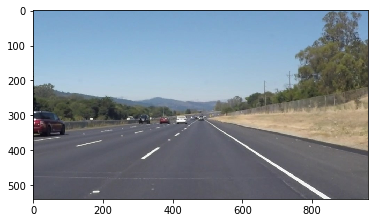

In [0]:
#reading in an image
image = mpimg.imread(os.path.join(TEST_IMAGES_DIR, 'solidWhiteRight.jpg'))

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [0]:
def displayImages(images, cmap=None, figSize=(18, 18), cols=2):
    """ Display images in the notebook """
    
    rows = len(images) // cols + (len(images) % cols > 0)

    _, axes = plt.subplots(rows, cols, figsize=figSize)
    axes = axes.flatten()

    for image, axis in zip(images, axes):
        axis.imshow(image, cmap)
        axis.set_xticks([])
        axis.set_yticks([])

    plt.show()

In [0]:
def convertColorSpace(image, fromColorSpace, toColorSpace):
    """
    Convert image from one color space to another \n
    Most common `fromColorSpace` and `toColorSpace` arguments are \n
    `BGR`, `RGB`, `HSV`, `HLS` etc.
    """
    return cv2.cvtColor(image, getattr(cv2, f"COLOR_{fromColorSpace}2{toColorSpace}"))

def selectWhiteYellowLines(image):
    """
    This function extracts `White` and `Yellow` lane lines from the road using
    `cv2.inRange` function and some `bitwise` operations.
    """
    lowerWhite = np.uint8([200, 200, 200])
    upperWhite = np.uint8([255, 255, 255])
    maskWhite = cv2.inRange(image, lowerWhite, upperWhite)

    lowerYellow = np.uint8([200, 200,   0])
    upperYellow = np.uint8([255, 255, 255])
    maskYellow = cv2.inRange(image, lowerYellow, upperYellow)

    mask = cv2.bitwise_or(maskWhite, maskYellow)
    masked = cv2.bitwise_and(image, image, mask=mask)

    return masked

def blurAndEdges(image, thresholdLow, thresholdHigh, kernel=None):
    """
    This function is used for `Gaussian Blurring` and `Edge Detection`. If the
    `kernal` parameter is not provided, blurring part is skipped.
    """
    if kernel:
        image = cv2.GaussianBlur(image, (kernel, kernel), 0)
    return cv2.Canny(image, thresholdLow, thresholdHigh)

def regionOfInterest(image):
    """
    This function is for finding a `Region of Interest` (ROI) in the image.
    Everthing except the contents of ROI is masked.
    """

    rows, cols = image.shape[:2]
    
    topLeft     = [cols * 0.4, rows * 0.6]
    topRight    = [cols * 0.6, rows * 0.6] 
    bottomLeft  = [cols * 0.1, rows * 0.95]
    bottomRight = [cols * 0.9, rows * 0.95]
    
    vertices = np.array([[bottomLeft, topLeft, topRight, bottomRight]], dtype=np.int32)

    mask = np.zeros_like(image)   
    
    if len(image.shape) > 2:
        channelCount = image.shape[2]
        ignoreMaskColor = (255,) * channelCount
    else:
        ignoreMaskColor = 255
        
    cv2.fillPoly(mask, vertices, ignoreMaskColor)
    
    maskedImage = cv2.bitwise_and(image, mask)

    return maskedImage

def weightedImage(image, initialImage, alpha=0.8, beta=1., gamma=0.):
    return cv2.addWeighted(initialImage, alpha, image, beta, gamma)

def getValidSlopeLines(lines, slopeThreshold=0.5):
    """
    This function checks whether it is possible to compute the slope of the 
    line. It returns the lines as well as their slopes 
    """
    slopes = []
    newLines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        if x2 - x1 == 0.:
            slope = 500.
        else:
            slope = (y2 - y1) / (x2 - x1)
        
        if abs(slope) > slopeThreshold:
            slopes.append(slope)
            newLines.append(line)

    return newLines, slopes

def splitLines(lines, slopes):
    """
    This function splits the lines based on whether their slopes are 
    negative or positive which corresponds to whether they are part of right
    lane line or left lane line 
    """
    rightLines = []
    leftLines = []

    for c, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]

        if slopes[c] > 0:
            rightLines.append(line)
        elif slopes[c] < 0:
            leftLines.append(line)

    return rightLines, leftLines

def getLinearRegressionFit(lines):
    """
    This function approximates a straight line through a set of x and y points
    using `np.polyfit` function 
    """
    if len(lines) > 0:
        x = []
        y = []

        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            x.append(x1)
            x.append(x2)
            y.append(y1)
            y.append(y2)
            
        slope, intercept = np.polyfit(x, y, 1)
        
        return True, slope, intercept, min(y)
    else:
        return False, None, None, None

def drawLines(image, lines, color=[255, 0, 0], thickness=6):
    """
    This function draws lines calculated by `houghTransform` function
    """
    lines, slopes = getValidSlopeLines(lines)
    rightLines, leftLines = splitLines(lines, slopes)
    drawLeft, leftLineSlope, leftLineIntercept, yMinLeft = getLinearRegressionFit(rightLines)
    drawRight, rightLineSlope, rightLineIntercept, yMinRight = getLinearRegressionFit(leftLines)
    
    if drawLeft and drawRight:
        y1 = image.shape[0]
        y2 = min(yMinLeft, yMinRight)
        
        x1Left = (y1 - leftLineIntercept) / leftLineSlope
        x2Left = (y2 - leftLineIntercept) / leftLineSlope
        
        x1Right = (y1 - rightLineIntercept) / rightLineSlope
        x2Right = (y2 - rightLineIntercept) / rightLineSlope
        
        y1, y2, x1Left, x2Left, x1Right, x2Right = \
            [int(i) for i in [y1, y2, x1Left, x2Left, x1Right, x2Right]]
        
        cv2.line(image, (x1Right, y1), (x2Right, y2), color, thickness)
        cv2.line(image, (x1Left, y1), (x2Left, y2), color, thickness)

def houghTransform(image, rho, theta, threshold, minLineLength, maxLineGap):
    """
    This function performs the Probabilistic Hough Line Transform and draws 
    those lines on the images
    """
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=minLineLength, maxLineGap=maxLineGap)
    lineImage = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    drawLines(lineImage, lines)
    return lineImage

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [0]:
os.listdir(TEST_IMAGES_DIR)

['solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg']

If you wish to see all the intermediate outputs, uncomment the following code blocks and run the notebook again.

In [0]:
# lineImages = list(map(selectWhiteYellowLines, testImages))
# displayImages(lineImages)

In [0]:
# grayImages = [convertColorSpace(image, "RGB", "GRAY") for image in lineImages]
# displayImages(grayImages, cmap="gray")

In [0]:
# edgeImages = [blurAndEdges(image, 50, 150, 5) for image in grayImages]
# displayImages(edgeImages, cmap="gray")

In [0]:
# roiImages = [regionOfInterest(image) for image in edgeImages]
# displayImages(roiImages, cmap="gray")

In [0]:
# lineImages = [houghTransform(image, 2, np.pi / 180, 15, 10, 20) for image in roiImages]
# weightedImages = [weightedImage(lineImage, testImage) for lineImage, testImage in zip(lineImages, testImages.copy())]
# displayImages(weightedImages)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

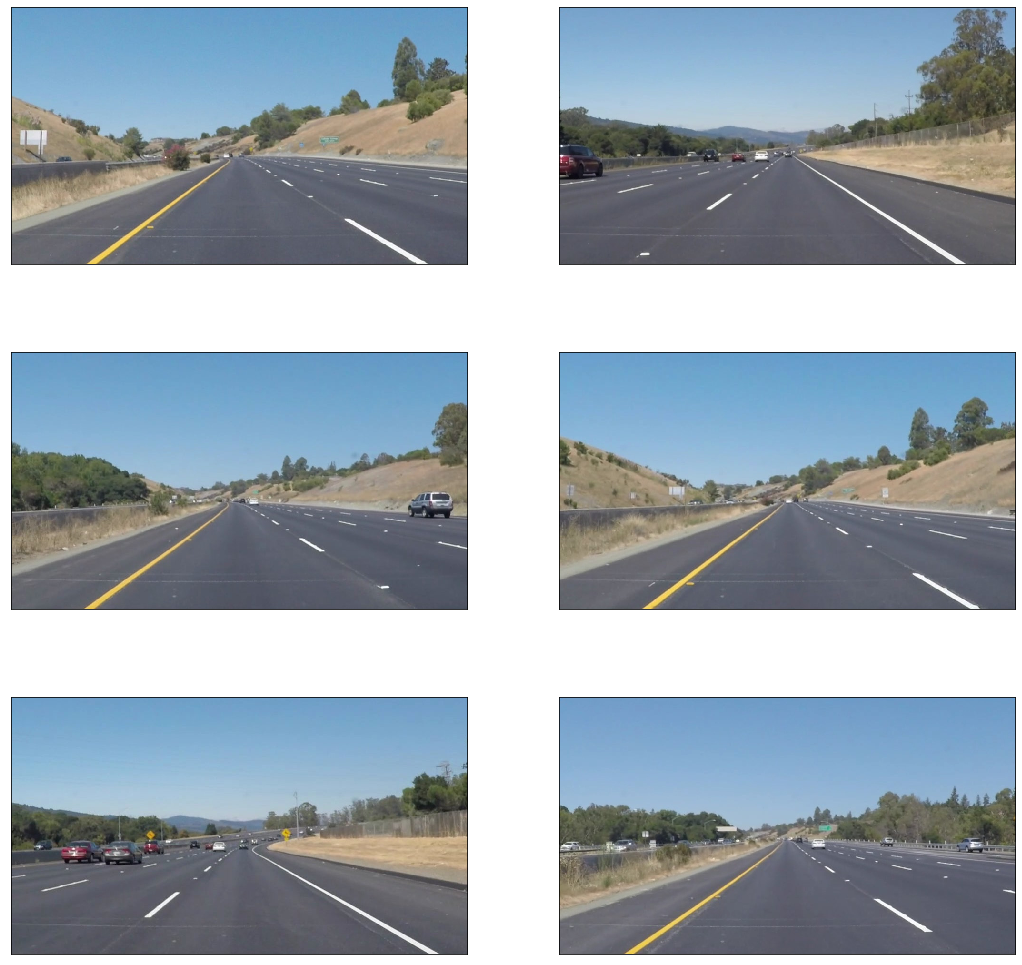

In [0]:
TEST_IMAGES_PATHS = [os.path.join(TEST_IMAGES_DIR, _) for _ in os.listdir(TEST_IMAGES_DIR)]
testImages = [mpimg.imread(_) for _ in TEST_IMAGES_PATHS]
displayImages(testImages)

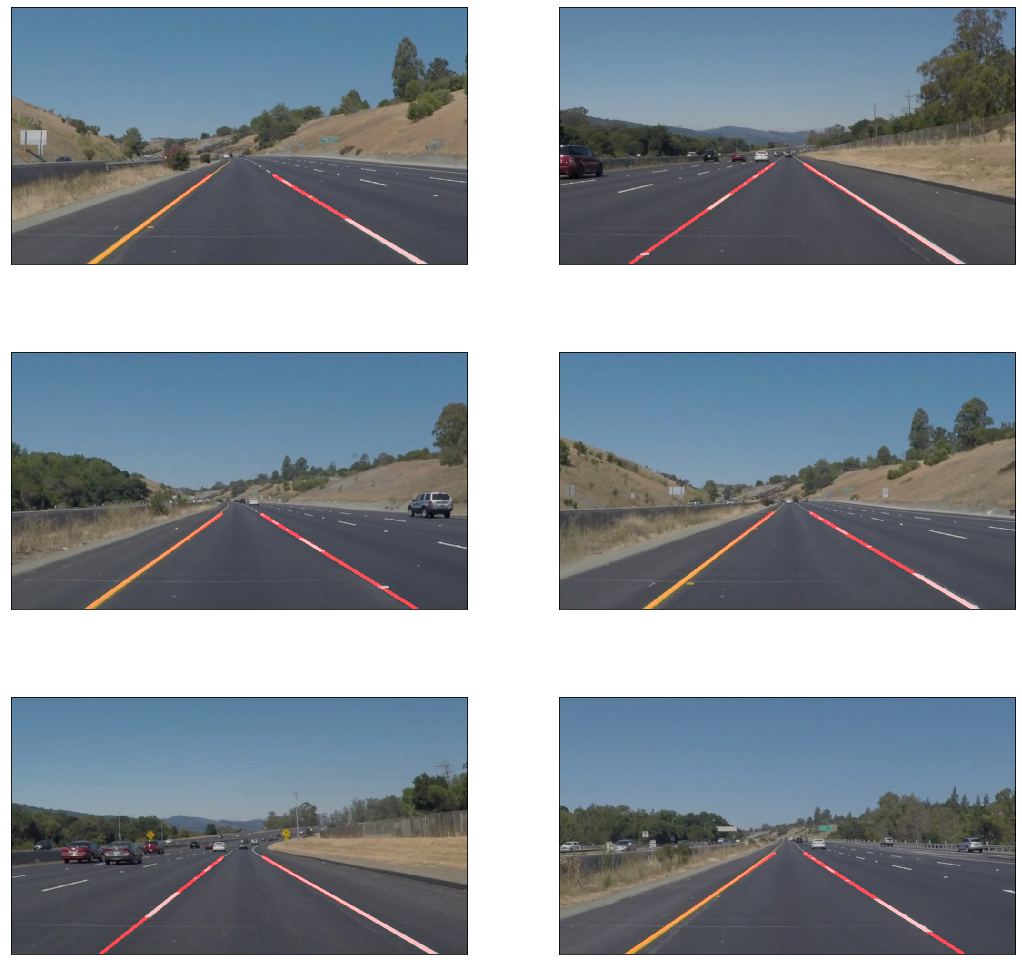

In [0]:
def findLaneLines(image):
    selectlines = selectWhiteYellowLines(image)
    gray = convertColorSpace(selectlines, "RGB", "GRAY")
    edges = blurAndEdges(gray, 50, 150, 5)
    roi = regionOfInterest(edges)
    lines = houghTransform(roi, 2, np.pi / 180, 15, 10, 20)
    output = weightedImage(lines, image.copy())
    return output

OUTPUT_IMAGES_PATHS = [os.path.join(OUTPUT_IMAGES_DIR, _) for _ in os.listdir(TEST_IMAGES_DIR)]

outputs = []
for inp_path, oup_path in zip(TEST_IMAGES_PATHS, OUTPUT_IMAGES_PATHS):
    output = findLaneLines(mpimg.imread(inp_path))
    cv2.imwrite(oup_path, convertColorSpace(output, "RGB", "BGR"))
    outputs.append(output)

displayImages(outputs)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [0]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [0]:
TEST_VIDEO_PATHS = [os.path.join(TEST_VIDEOS_DIR, _) for _ in os.listdir(TEST_VIDEOS_DIR)]
OUTPUT_VIDEO_PATHS = [os.path.join(OUTPUT_VIDEOS_DIR, _) for _ in os.listdir(TEST_VIDEOS_DIR)]

for test, output in zip(TEST_VIDEO_PATHS, OUTPUT_VIDEO_PATHS):
    clip1 = VideoFileClip(test)
    white_clip = clip1.fl_image(findLaneLines)
    %time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/challenge.mp4
[MoviePy] Writing video /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:26<00:00,  8.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/challenge.mp4 

CPU times: user 8.3 s, sys: 744 ms, total: 9.04 s
Wall time: 29.7 s
[MoviePy] >>>> Building video /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:11<00:00, 17.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.44 s, sys: 437 ms, total: 4.88 s
Wall time: 12.9 s
[MoviePy] >>>> Building video /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:37<00:00, 18.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/Udacity/Self-driving Car Engineer/Projects/01 Finding Lane Lines/test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.7 s, sys: 1.17 s, total: 14.9 s
Wall time: 39.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [0]:
HTML('<iframe width="960" height="540" src="https://www.youtube.com/embed/IEJcpWljbYA?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [0]:
HTML('<iframe width="960" height="540" src="https://www.youtube.com/embed/_Bsul79kVE8?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

In [0]:
HTML('<iframe width="960" height="540" src="https://www.youtube.com/embed/be8Es080aOA?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


# Pipeline

My lane detection pipeline consists of **5 steps** which are as follows:
* Find **White** and **Yellow** regions of the image
* Apply **Gaussian Blurring** and **Canny Edge Detection**
* Mask everything except our **Region of Interest**
* Apply **Probabilistic Hough Line Transform** to find straight lines
* **Draw** the lines and apply **Linear Regression** to find just **two** (*Left* and *Right*) lines

# Potential Shortcomings
1. One major and obvious shortcoming, as seen in [challenge.mp4](https://youtu.be/be8Es080aOA) video, is that this pipeline does not perform well in **varying lighting conditions**.


2. This pipeline also does not perform well on **curved lines** because we are fitting a straight line through the points.

# Suggest Improvements

1. We'll need to use sophisticated techniques (**HLS** color space etc.) to make it perform better under changing lighting conditions.

2. To make it work on **road turns** we'll need to use some better approach and fit a **higher degree polynomial** so that we can account for curved lines as well.